## Feedback 

### 1. Bias and variance of ridge regression
<div style="color: green; font-weight:bold">
Expectation of β:
- We use the solution for ridge regression obtained in the lecture (without deriving it again).
<br>
- We correctly substitute y as in the sample solution.
<br>
- We use the linearity of the expected value and the fact that the expected value of ε is 0 and arrive at the desired result as in the sample solution.
<br>
- We only include the scatter matrices S and S_τ in the formula in the end (unlike the sample solutions).
<br>
<br>
Covariance of β:
<br>
- Unlike the sample solutions, we do not work with the definition of the covariance.
<br>
- We use two properties of the covariance:
<br>
    - covariance of a constant is 0.
    <br>
    - Cov(AY) = ACov(Y)A^T for a matrix A and a random variable Y (this property is not correctly stated in our solutions).
    <br>
- At last we use the covariance of ε and the symmetry of S_τ and arrive at the desired result.
</div>

### 2. LDA-Derivation from the Least Squares Error

<div style="color: green; font-weight:bold">
- We also arrive at eq. (25) from the sample solution, but we divide it by the factor 1/N (our equation is marked with (*)).
<br>
- We also consider the two summands separately (marked in orange and in purple). In the sample solutions these would be the left and the right hand side.
<br>
- We easily reformulate the first summand in terms of the two means (as in the sample solutions).
<br>
- For the second summand (marked in purple), we use the second appraoch from the sample solutions.
<br>
- In the end, we obtain the desired equation.
</div>

In [16]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
def import_data(standardize=False):
    digits = load_digits()
    # print (digits.keys())
    data = digits["data"]
    images = digits["images"]
    target = digits["target"]
    target_names = digits["target_names"]

    threes = np.array([images[i] for i in range (len(images)) if target[i] == 3])
    nines = np.array([images[i] for i in range (len(images)) if target[i] == 9])

    filter_indices = np.where((digits.target == 3) | (digits.target == 9))[0]
    filtered_data = digits.data[filter_indices]
    filtered_target = digits.target[filter_indices]

    if standardize:
        scaler = StandardScaler()
        filtered_data = scaler.fit_transform(filtered_data)

    X_train, X_test, y_train, y_test = train_test_split(filtered_data, filtered_target, test_size=0.2, random_state=0,shuffle=True)

    return X_train, X_test, y_train, y_test



In [18]:
def transform_labels(y):
    y[y == 3] = -1
    y[y == 9] = 1
    return y

def predict(X,beta_hat):
    return np.sign(np.dot(X, beta_hat)).astype(int)

def error(labels,predicted_labels):
    return np.sum(labels != predicted_labels)/labels.shape[0]

<div style="color: green; font-weight:
bold">

<p> We use np.linalglstsq instead of calculating the inverse and using the complete form, but I believe that this yields the same result because the pseudoinverse minimizes the MSE of the residual which is equivalent to using np.linalglstsq directly. </p>

<p> We reconstruct a new full_beta_t iteratively instead of using numpy array comprehension like in the given solution. </p>

</div>

In [19]:
def omp_regression_gpt(X,y,T):
    # Initialization
    N, D = X.shape
    A = []  # Active set
    B = list(range(D))  # Inactive set
    r = y  # Initial residual
    solutions = np.zeros((D, T))  # To store solutions for each t

    for t in range(T):
        # Step 1: Find the inactive column with the maximum correlation with the residual
        correlations = np.abs(np.dot(X[:, B].T, r))
        j = B[np.argmax(correlations)]
        
        # Step 2: Move j from B to A
        A.append(j)
        B.remove(j)
        
        # Step 3: Form the active matrix X(t)
        X_t = X[:, A]
        
        # Step 4: Solve the least squares problem
        beta_t, _, _, _ = np.linalg.lstsq(X_t, y, rcond=None)
        
        # Create the full beta vector with zeros at inactive positions
        full_beta_t = np.zeros(D)
        for idx, active_idx in enumerate(A):
            full_beta_t[active_idx] = beta_t[idx]
        
        # Step 5: Update the residual
        r = y - np.dot(X, full_beta_t)
        
        # Store the solution
        solutions[:, t] = full_beta_t

    return solutions

<div style="color: green; font-weight:
bold">

We didnt check for the balance of the 3s and 9s classes.

</div>

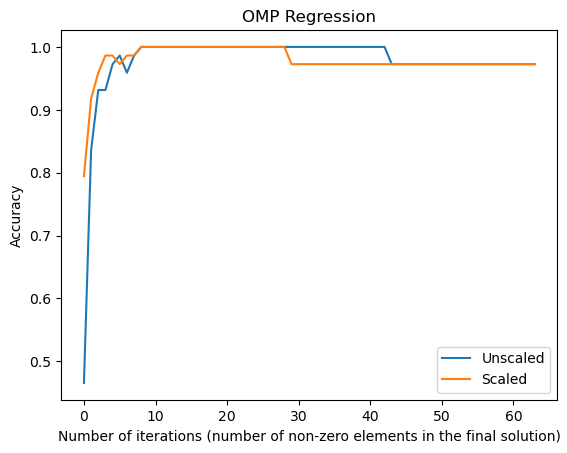

In [20]:
T = 64
X_train, X_test, y_train, y_test = import_data(standardize=False)
X_train_scaled, X_test_scaled, _, _ = import_data(standardize=True)

beta_hats = omp_regression_gpt(X_train, transform_labels(y_train), T)
beta_hats_scaled = omp_regression_gpt(X_train_scaled, transform_labels(y_train), T)

## iterate over beta_hats
accuracy = []
accuracy_scaled = []
for i in range(beta_hats.shape[1]):
    y_hat = predict(X_test, beta_hats[:, i])
    y_hat_scaled = predict(X_test_scaled, beta_hats_scaled[:, i])
    # print(1 - error(transform_labels(y_test), y_hat))
    accuracy.append(1 - error(transform_labels(y_test), y_hat))
    accuracy_scaled.append(1 - error(transform_labels(y_test), y_hat_scaled))

plt.plot(accuracy)
plt.plot(accuracy_scaled)
plt.legend(["Unscaled", "Scaled"])
plt.xlabel("Number of iterations (number of non-zero elements in the final solution)")
plt.ylabel("Accuracy")
plt.title("OMP Regression")
plt.show()

<div style="color: green; font-weight:
bold">

We observe the same behaviour as in the given solution. Note that we report accuracy not error. We only report the accuracy for the train set.

</div>

In [21]:
# Determine number of pixels for acceptable error rate
acceptable_error_rate = 0.9  # Define an acceptable error rate
num_pixels_std = np.argmax(np.array(accuracy) >= acceptable_error_rate)
num_pixels_non_std = np.argmax(np.array(accuracy_scaled) >= acceptable_error_rate)

print(f"Number of pixels for acceptable error rate (standardized): {num_pixels_std}")
print(f"Number of pixels for acceptable error rate (non-standardized): {num_pixels_non_std}")

Number of pixels for acceptable error rate (standardized): 2
Number of pixels for acceptable error rate (non-standardized): 1


We see that 2 pixels are enough to distinguish between the two classes with an accuracy of over 90%.

In [22]:
# Visualize the order of active pixels
def visualize_active_pixels(solutions, title):
    active_pixels = np.zeros(solutions.shape[0])
    for t in range(solutions.shape[1]):
        active_pixels[solutions[:, t] != 0] += 1
        plt.imshow(active_pixels.reshape(8, 8), cmap='hot', interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        plt.show()

def visualize_active_pixels_grid(solutions, title, grid_size=(8, 8)):
    num_images = solutions.shape[1]
    img_size = int(np.sqrt(solutions.shape[0]))

    # Calculate number of rows and columns for the grid
    num_cols = grid_size[0]
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    fig.suptitle(title)


    active_pixels = np.zeros(solutions.shape[0])
    for t in range(num_images):
        active_pixels[solutions[:, t] != 0] += 1
        row, col = divmod(t, num_cols)
        ax = axes[row, col]
        ax.imshow(active_pixels.reshape(img_size, img_size), cmap='hot', interpolation='nearest')
        
        ax.set_title(f't = {t + 1}')
        ax.axis('off')
        
    # Turn off any unused subplots
    for t in range(num_images, num_rows * num_cols):
        row, col = divmod(t, num_cols)
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top to fit the main title
    plt.show()


<div style="color: green; font-weight:
bold">

Our next visualization shows the importance of each pixel when we increase t (the number of non-zero elements) for both the standardized and non standardized features.

</div>

### Non-standardized features

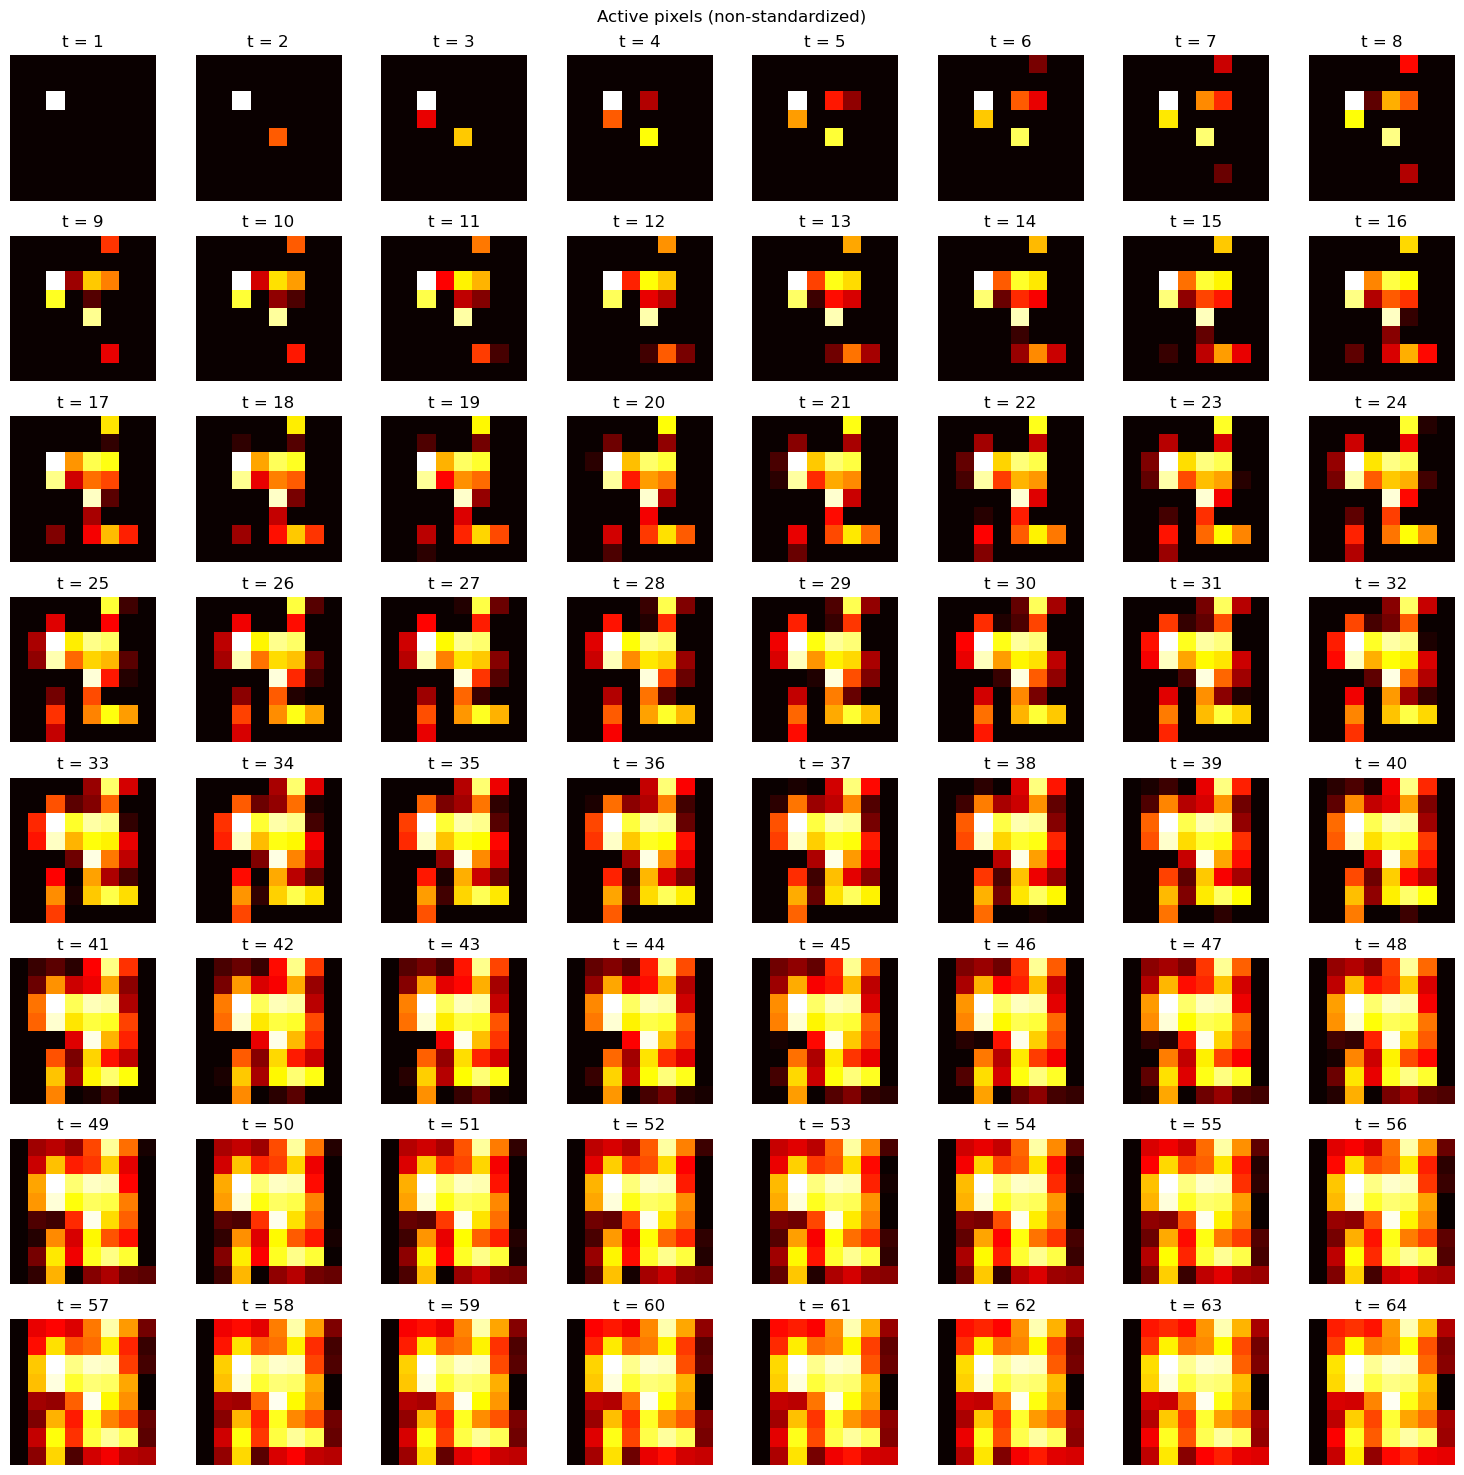

In [23]:
visualize_active_pixels_grid(beta_hats, "Active pixels (non-standardized)")

### Standardized features

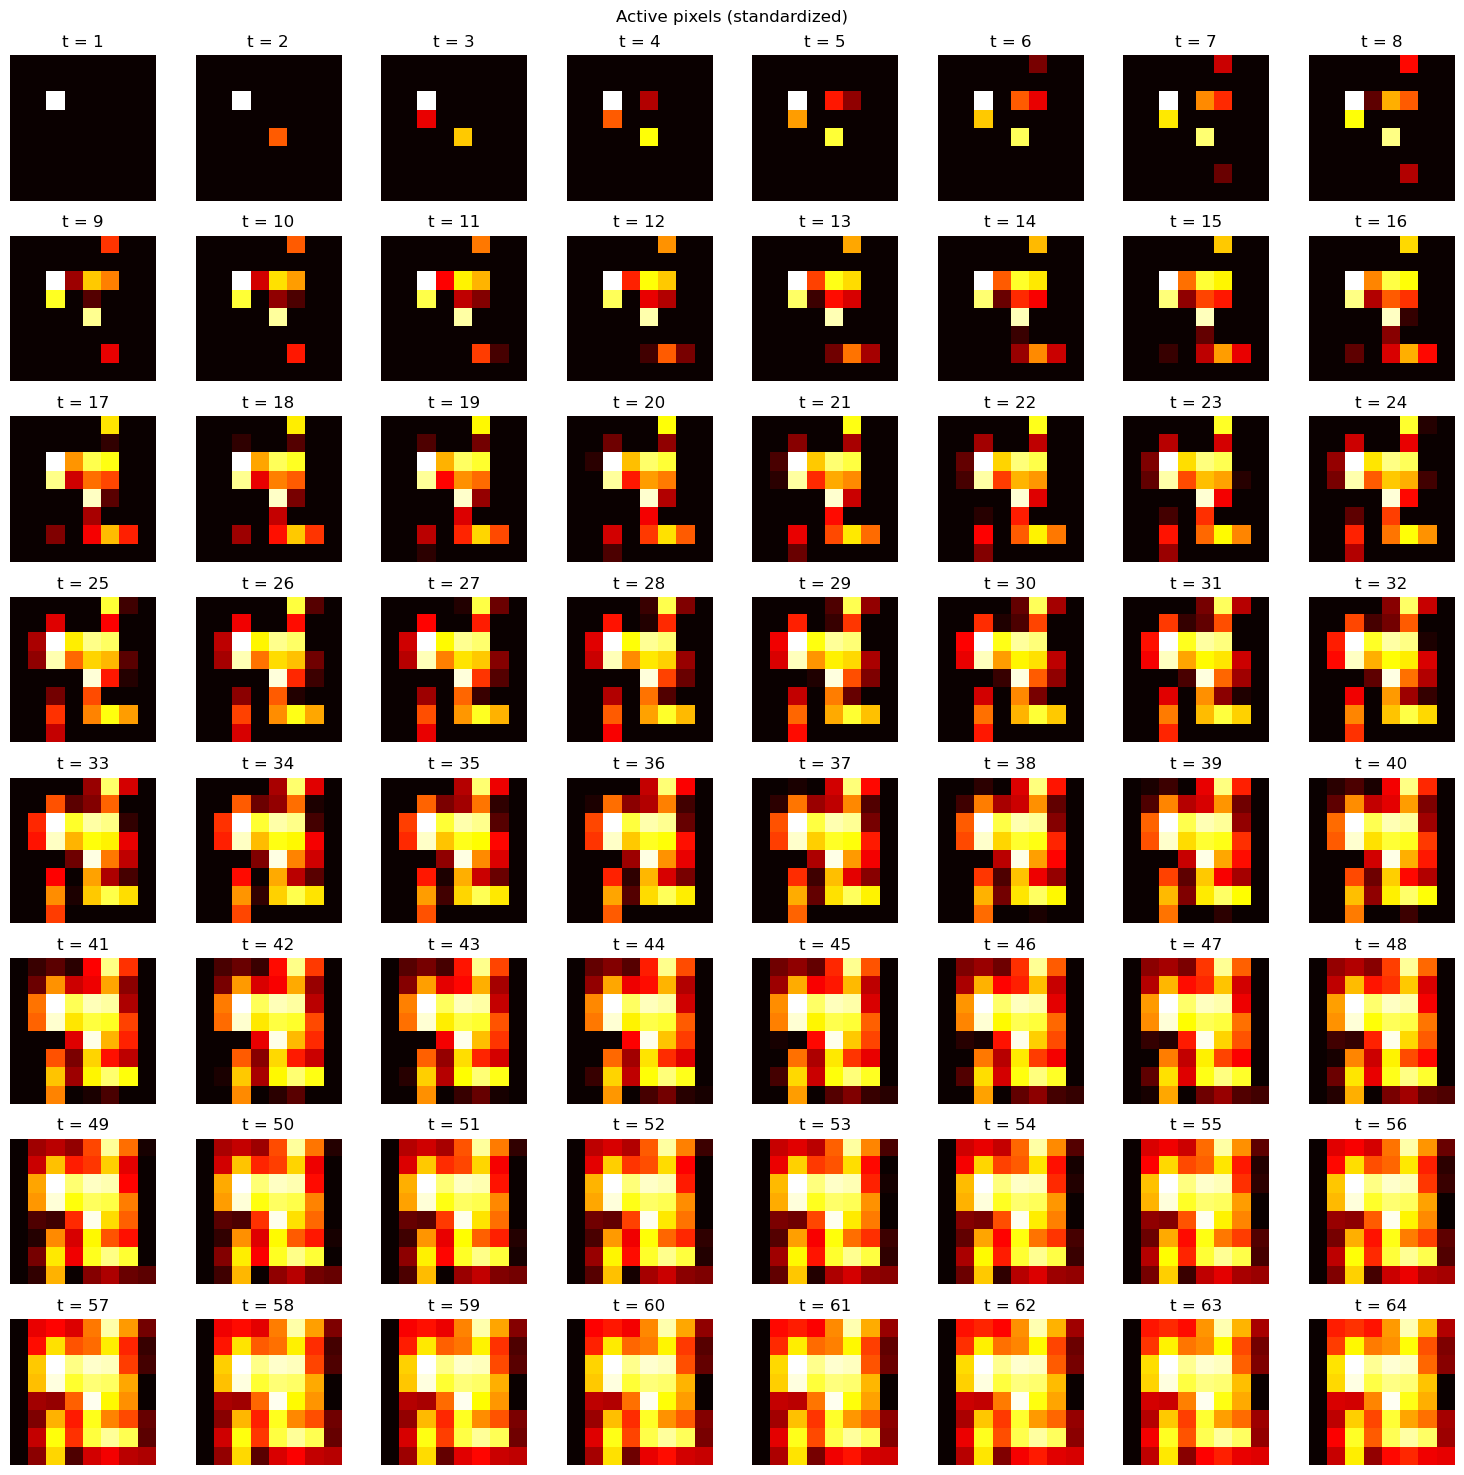

In [24]:
visualize_active_pixels_grid(beta_hats, "Active pixels (standardized)")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_active_pixels_votes(solutions, title, grid_size=(8, 8)):
    num_images = solutions.shape[1]
    img_size = int(np.sqrt(solutions.shape[0]))

    # Calculate number of rows and columns for the grid
    num_cols = grid_size[0]
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    fig.suptitle(title)

    # Custom color map: positive (red), negative (blue), zero (white)
    cmap = ListedColormap(['blue', 'white', 'red'])
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for t in range(num_images):
        active_pixels = np.zeros(solutions.shape[0])
        active_pixels[solutions[:, t] > 0] = 1   # Vote towards 3 (positive coefficients)
        active_pixels[solutions[:, t] < 0] = -1  # Vote towards 9 (negative coefficients)
        
        ax = axes[t]
        cax = ax.matshow(active_pixels.reshape(img_size, img_size), cmap=cmap)
        ax.set_title(f't = {t + 1}')
        ax.axis('off')
        
    # Turn off any unused subplots
    for t in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[t])
        
    # Add a colorbar to indicate voting direction
    # fig.colorbar(cax, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05, ticks=[-1, 0, 1])
    # cbar = fig.colorbar(cax, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05, ticks=[-1, 0, 1])
    # cbar.ax.set_xticklabels(['Votes 9', 'Inactive', 'Votes 3'])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top to fit the main title
    plt.show()


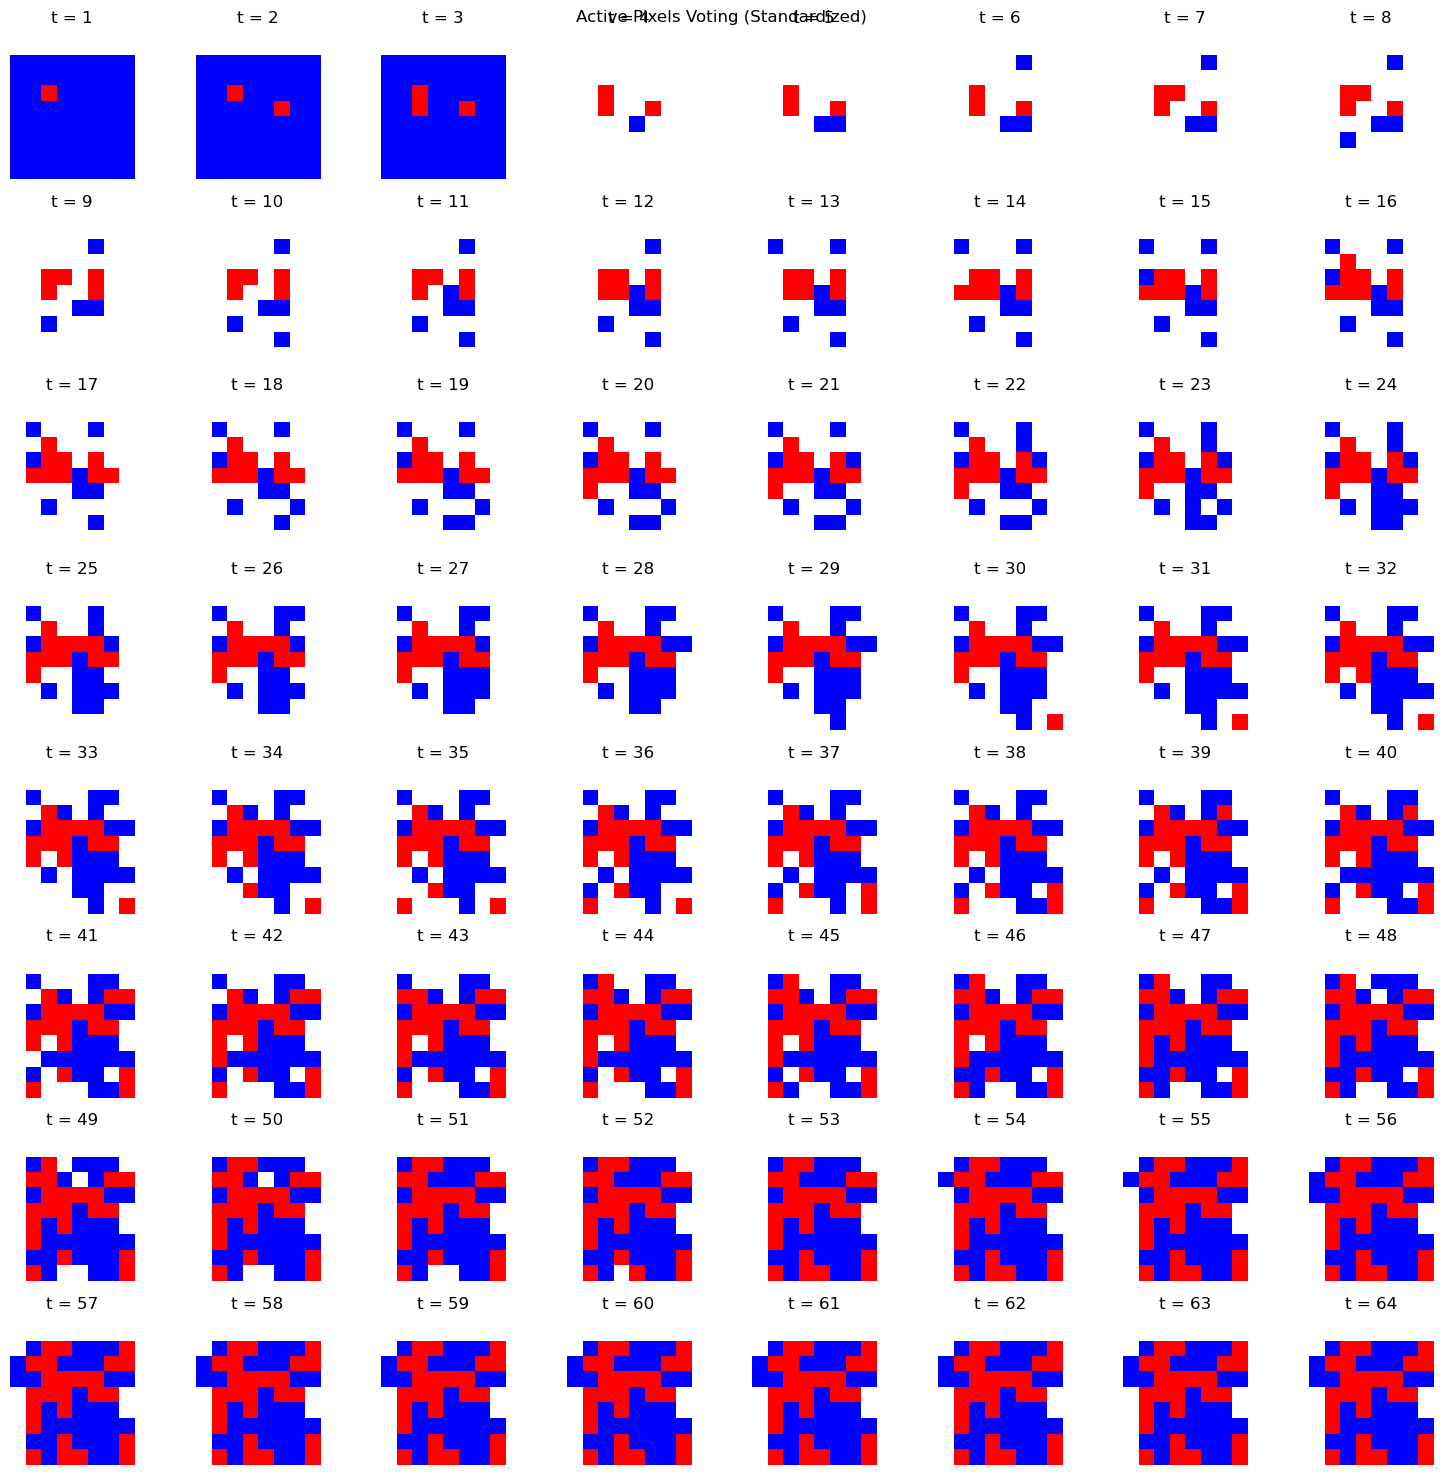

In [26]:
visualize_active_pixels_votes(beta_hats_scaled, "Active Pixels Voting (Standardized)")

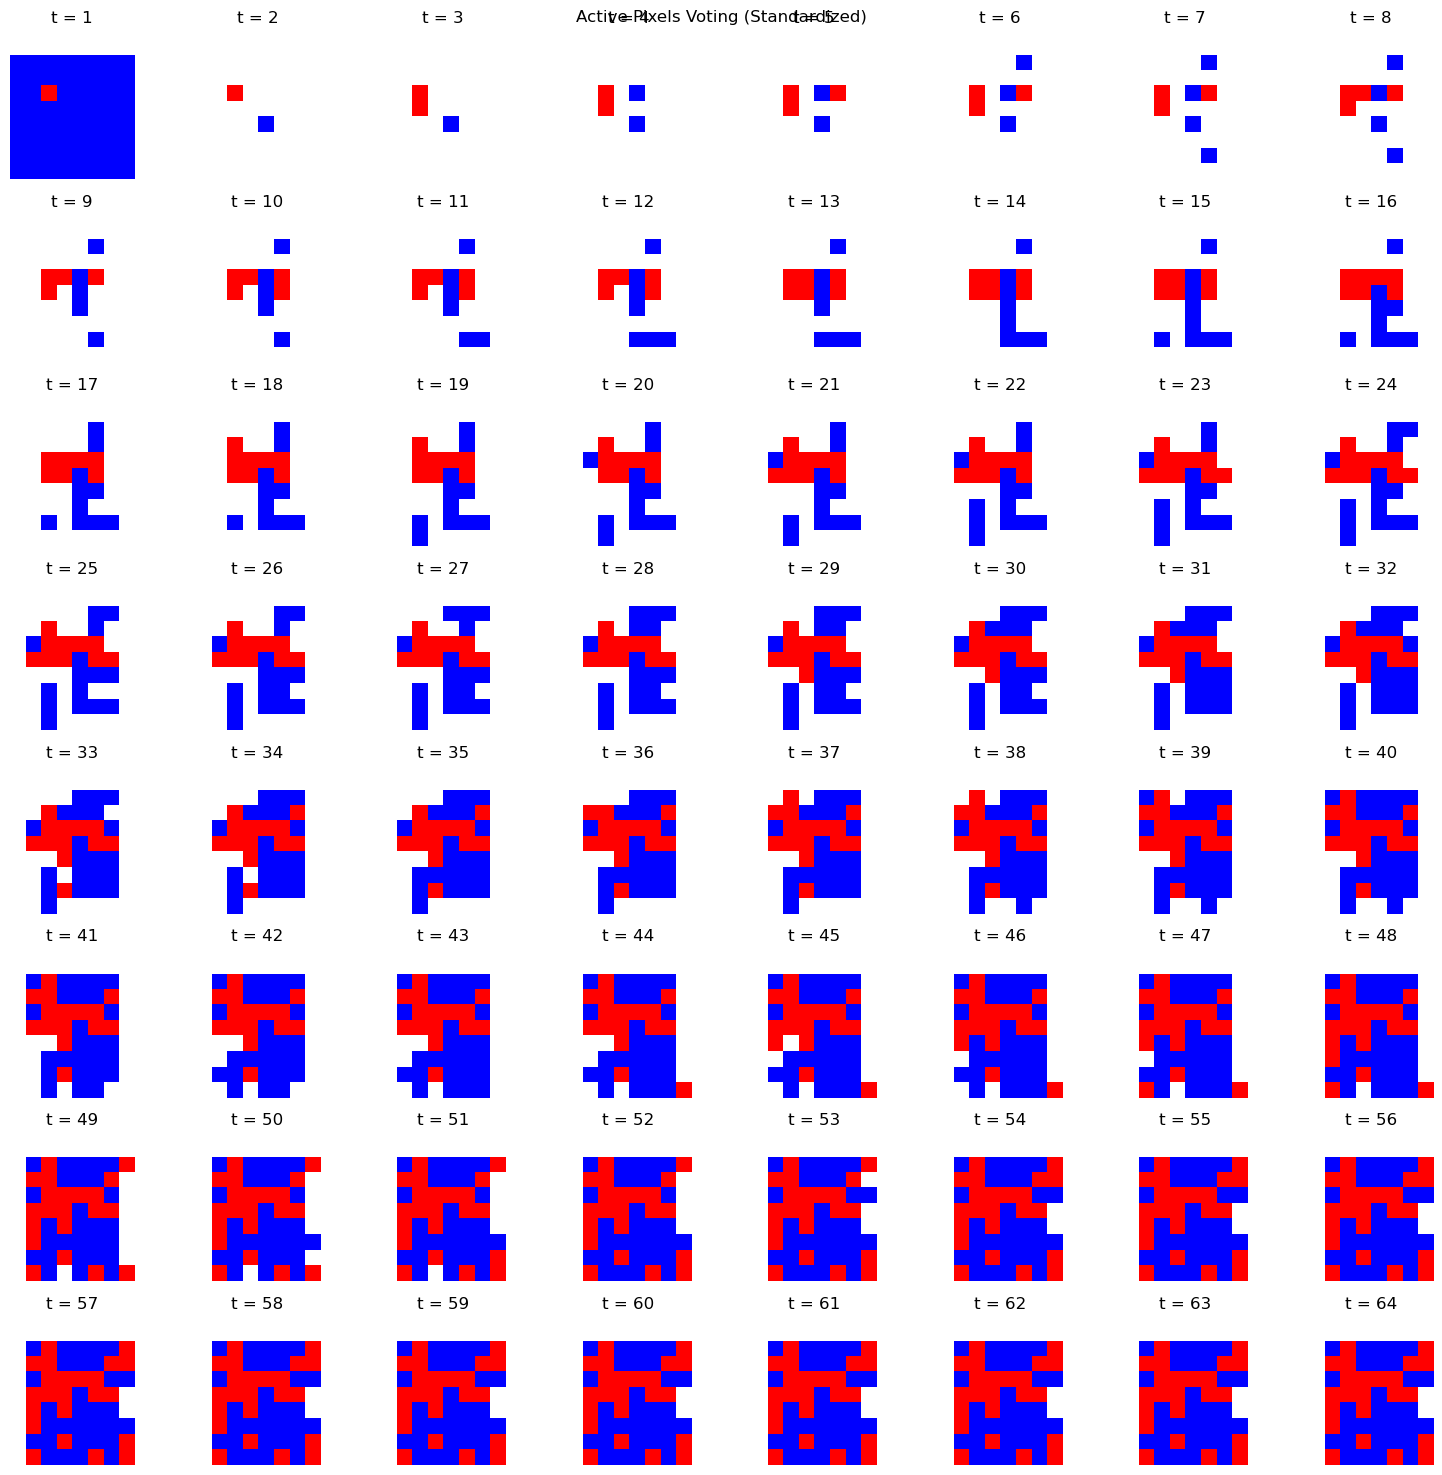

In [27]:
visualize_active_pixels_votes(beta_hats, "Active Pixels Voting (Non-Standardized)")

#### Conclusion

We observe that the a good criterion for distinction between 3 and 9 are the pixels that close the outer loop of the 9, which makes sense intuitivly because that is indeed the graphical difference between a 3 and a 9. Those are the same pixels we selected in assigment 1.